In [1]:
import torch
import torch.nn as nn
import torchvision
import os

import numpy as np
from PIL import Image
from tqdm import tqdm
from livelossplot import PlotLosses

from sklearn.metrics import classification_report, f1_score
%pylab inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.utils import class_weight

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Change path to root folder of the data provided
path_to_data = '../data/combined/'

# a dataset abstraction that figures out classes on it's own based on what folder the images were in
_data = torchvision.datasets.DatasetFolder(
    path_to_data,                                  # root path, it'll get paths to actual images on it's own
    Image.open,                                    # pillow open image function to load data from given path
    ['jpg', 'JPG', 'HEIC', 'jpeg', 'jfif'],                                # list of extensions for images in dataset
    transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
#             torchvision.transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomApply([
            torchvision.transforms.RandomHorizontalFlip(p=1.0),
            torchvision.transforms.RandomVerticalFlip(p=1.0),
            torchvision.transforms.ColorJitter(
                brightness=0.7,
                contrast=0.7,
                saturation=0.7,
                hue=0.3),
            torchvision.transforms.RandomRotation(15),
        ]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                 std=[0.229, 0.224, 0.225]),
        # images using this normalisation parameters
    ]),
)

print("Found", str(len(_data)), "images.")
def _find_classes(dir):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

classes, class_to_idx = _find_classes(path_to_data)
idx_to_classes = {v: k for k, v in class_to_idx.items()}

Found 3010 images.


In [3]:
# some unfortunate ugly code to split the data randomly into training and testing
split_at = 1
train, test = torch.utils.data.random_split(
    _data,
    [int(split_at*(len(_data))), len(_data) - int(split_at*(len(_data)))]
)

In [4]:
batch_size = 16
# defining loaders for the train and test datasets
train_batches = torch.utils.data.DataLoader(
    train,                                       # dataset 
    batch_size=batch_size,                       # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

# test_batches = torch.utils.data.DataLoader(
#     test,                                       # dataset 
#     batch_size=batch_size,                      # size of batches to load
#     shuffle=True,
#     num_workers=8,                               # no of workers
#     pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
# ) 

labels = []
for batch in tqdm(train_batches):
    for x in batch[1]:
        labels.append(x.item())

class_weights = class_weight.compute_class_weight(
        'balanced', np.unique(labels), np.array(labels))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [01:02<00:00,  3.02it/s]


In [5]:
# it'll download alexnet weights on it's own
squeezenet = torchvision.models.squeezenet1_1(
    pretrained=True,
)


c:\users\dhruv\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
c:\users\dhruv\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [6]:
# get list of classes from names of folders inside the path to data
label_names = classes

# set num of classes, so as to set the output dimensions
squeezenet.num_classes = len(label_names)
label_names

['FEIT_40W_T8_TUBE_MCRWV_BULB_120V',
 'GE_40W_RelaxLED',
 'GE_60W_LED_A19_FROST_5000K_8CT',
 'GE_Appliance_LED_11W_Soft_White',
 'GE_Appliance_LED_40W_Warm_White',
 'GE_Basic_LED_60W_Soft_Light',
 'GE_Basic_LED_90W_Daylight',
 'GE_Classic_LED_65W_Soft_White',
 'GE_Vintage_LED_60W_Warm_Light',
 'OSI_60W_13W_CFL_SOFT_WHITE_6_CT',
 'There_Is_No_Bulb']

In [7]:
# create new instances of the same layers, to get rid of the pretrained weights in the classification layers
# we want to learn our own
layers = [
#     nn.BatchNorm2d(512),
    nn.Dropout(0.5),
    nn.Conv2d(512, squeezenet.num_classes, kernel_size=(1, 1), stride=(1, 1)),
#     nn.BatchNorm2d(squeezenet.num_classes),
    nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
    nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
]

# change the classification layers to the untrained ones we just defined
# I am not sure why this syntax works, I found it in a medium article
squeezenet.classifier = nn.Sequential(*layers)
# but it gets the job done
squeezenet.classifier

Sequential(
  (0): Dropout(p=0.5)
  (1): Conv2d(512, 11, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace)
  (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
)

In [8]:
loss = nn.CrossEntropyLoss(
    weight = torch.tensor(class_weights).half().to(device)
)                # loss function
# it's softmax followed by Negative Log Likelihood loss

# defining an optimizer
optimizer = torch.optim.Adam(
    squeezenet.parameters(),   
    lr=1e-4,
    amsgrad = True,
    eps=1e-4
)

squeezenet.half()
squeezenet.to(device)           # load up all the weights to cuda device memory, if available
live_losses = PlotLosses()   # a tool for drawing plots

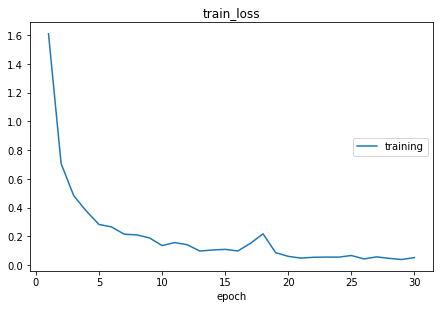

train_loss:
training   (min:    0.039, max:    1.610, cur:    0.053)


In [9]:
# training
for epoch in range(30):
    squeezenet.train()  # set model to train mode. not sure what that does, probably some optimisations
    
    train_errors = []  
    test_errors = []
    for batch in (tqdm(train_batches)):
        X, Y = batch
        pred = squeezenet(X.half().to(device))
        
        optimizer.zero_grad()               # reset the gradients
        error = loss(pred, Y.to(device))    # get loss
        error.backward()                    # propogate loss backwards
        optimizer.step()                    # update params
        
        train_errors.append(error.data.item())
        
    
    squeezenet.eval()  # set model to evaluate mode. not sure what that does exactly
    
    # some code to calculate f1 score for the test set
    predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
    test_predictions = []
    test_actual = []
#     for batch in test_batches:
#         x, y = batch
#         pred = squeezenet(x.half().to(device))
#         test_predictions.append(predict(pred))
#         test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
#         test_actual.append(np.array(y))
    
#     train_predictions = []
#     train_actual = []
#     for batch in train_batches:
#         x, y = batch
#         pred = squeezenet(x.to(device))
#         train_predictions.append(predict(pred))
#         train_actual.append(np.array(y))

    # log data to be plotted later
    live_losses.update({
        'train_loss': np.mean(np.array(train_errors)),
#         'test_loss': np.mean(np.array(test_errors)),
#         'train_f1': f1_score(np.concatenate(train_actual), np.concatenate(train_predictions), average='weighted'),
#         'test_f1': f1_score(np.concatenate(test_actual), np.concatenate(test_predictions), average='weighted'),
    })
    live_losses.draw() # plot loss curves   



In [10]:
# print(classification_report(
#     np.concatenate(train_actual),
#     np.concatenate(train_predictions),
#     labels = range(len(label_names)),
#     target_names = label_names
# ))


print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

ValueError: need at least one array to concatenate

In [11]:
torch.save({
'state_dict': squeezenet.state_dict(),
}, "squeeznet_full")

In [ ]:
# x = batch[0]
# y = batch[1]
# alexnet(x)
torch.cuda.memory_allocated()

In [ ]:
squeezenet

In [ ]:
x, y = next(batches)
%matplotlib inline
def show(img):
    plt.figure(figsize=(25,25))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
show(torchvision.utils.make_grid(x, padding=10, normalize=True))

In [ ]:
batches = iter(train_batches)

In [ ]:
import time

%matplotlib inline
i = 0
for batch in train_batches:
    x, y = batch
    plt.figure(figsize=(25,25))
    npimg = torchvision.utils.make_grid(x, padding=10, normalize=True).numpy()
    plt.imsave(str(i)+".jpg", np.transpose(npimg, (1,2,0)))
    i = i + 1


In [ ]:
# Change path to root folder of the data provided
path_to_data = '../data/combined/'

# a dataset abstraction that figures out classes on it's own based on what folder the images were in
_data = torchvision.datasets.DatasetFolder(
    path_to_data,                                  # root path, it'll get paths to actual images on it's own
    Image.open,                                    # pillow open image function to load data from given path
    ['jpg', 'JPG', 'HEIC', 'jpeg', 'jfif'],                                # list of extensions for images in dataset
    transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                 std=[0.229, 0.224, 0.225]),         # images using this normalisation parameters
    ]),
)

train_batches = torch.utils.data.DataLoader(
    _data,                                       # dataset 
    batch_size=32,                       # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

squeezenet = torchvision.models.squeezenet1_1()
squeezenet.num_classes = len(label_names)
# create new instances of the same layers, to get rid of the pretrained weights in the classification layers
# we want to learn our own
layers = [
#     nn.BatchNorm2d(512),
    nn.Dropout(0.5),
    nn.Conv2d(512, squeezenet.num_classes, kernel_size=(1, 1), stride=(1, 1)),
#     nn.BatchNorm2d(squeezenet.num_classes),
    nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
    nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
]

# change the classification layers to the untrained ones we just defined
# I am not sure why this syntax works, I found it in a medium article
squeezenet.classifier = nn.Sequential(*layers)

model = torch.load('../models/squeeznet_half')
squeezenet.load_state_dict(model['state_dict'])

squeezenet.half()
squeezenet.eval()
squeezenet.to(device)

predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
test_predictions = []
test_actual = []
for batch in tqdm(train_batches):
    x, y = batch
    pred = squeezenet(x.half().to(device))
    test_predictions.append(predict(pred))
    test_actual.append(np.array(y))

print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

In [ ]:
squeezenet.half()
squeezenet.eval()
predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
test_predictions = []
test_actual = []
for batch in test_batches:
    x, y = batch
    pred = squeezenet(x.half().to(device))
    test_predictions.append(predict(pred))
    test_errors.append(loss(pred, y.to(device)).data.item())    # get loss
    test_actual.append(np.array(y))

print(classification_report(
    np.concatenate(test_actual),
    np.concatenate(test_predictions),
    labels = range(len(label_names)),
    target_names = label_names
))

In [ ]:
# Change path to root folder of the data provided
path_to_data = '../data/combined/'

# a dataset abstraction that figures out classes on it's own based on what folder the images were in
_data = torchvision.datasets.DatasetFolder(
    path_to_data,                                  # root path, it'll get paths to actual images on it's own
    Image.open,                                    # pillow open image function to load data from given path
    ['jpg', 'JPG', 'HEIC', 'jpeg', 'jfif'],                                # list of extensions for images in dataset
    transform = torchvision.transforms.Compose([   # a pipeline of transformations to apply on the read image
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], # the documentation said that alexnet was modelled with
                                 std=[0.229, 0.224, 0.225]),         # images using this normalisation parameters
    ]),
)

In [ ]:
# some unfortunate ugly code to split the data randomly into training and testing
split_at = 1
train, test = torch.utils.data.random_split(
    _data,
    [int(split_at*(len(_data))), len(_data) - int(split_at*(len(_data)))]
)

batch_size = 32
# defining loaders for the train and test datasets
train_batches = torch.utils.data.DataLoader(
    train,                                       # dataset 
    batch_size=batch_size,                       # size of batches to load
    shuffle=True,
    num_workers=8,                               # no of workers
    pin_memory=True                              # Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a pin_memory() method, that returns a copy of the object, with data put in a pinned region.
) 

In [ ]:
labels = []
for batch in train_batches:
    x, y = batch
    labels.append(y.numpy())

In [ ]:
np.unique(labels[0])

In [ ]:
class_weight.compute_class_weight(
        'balanced', np.unique(labels[0]), labels[0])

class_weights = [0.66704036, 1.2192623 , 1.44417476, 1.17125984, 1.31637168,
       1.04020979, 1.35227273, 0.59738956]

In [ ]:
squeezenet.half()